<a href="https://colab.research.google.com/github/RiseAboveAll/RSNA_Pneumonia/blob/master/Interim_File_Final_Renamed_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import pydicom

import csv
import random

from glob import glob #The glob module finds all the pathnames matching a specified pattern according to the rules
import os

import tensorflow as tf
from tensorflow import keras

from skimage import measure
from skimage.transform import resize
from PIL import Image
from sklearn.model_selection import train_test_split as tts

import math
import cv2

from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import Conv2D, Reshape
from tensorflow.keras.utils import Sequence
from tensorflow.keras.backend import epsilon


c:\users\skillup 08\desktop\proj_env\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\skillup 08\desktop\proj_env\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\skillup 08\desktop\proj_env\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\skillup 08\desktop\proj_env\lib\site-pac

In [ ]:
detailed_class_df=pd.read_csv('stage_2_detailed_class_info.csv')
train_label_df=pd.read_csv('stage_2_train_labels.csv')

In [ ]:
detailed_class_df.describe()

,patientId,class
count,30227,30227
unique,26684,3
top,0ab261f9-4eb5-42ab-a9a5-e918904d6356,No Lung Opacity / Not Normal
freq,4,11821


In [ ]:
30227 - 26684

3543

There are potentially 3543 repetetive X-Rays of one patient , because the patients must have been asked to get his or her x-ray after some interval to see the progress or how worse the situation is 

In [ ]:
train_label_df.describe()

,x,y,width,height,Target
count,9555.000000,9555.000000,9555.000000,9555.000000,30227.000000
mean,394.047724,366.839560,218.471376,329.269702,0.316108
std,204.574172,148.940488,59.289475,157.750755,0.464963
min,2.000000,2.000000,40.000000,45.000000,0.000000
25%,207.000000,249.000000,177.000000,203.000000,0.000000
50%,324.000000,365.000000,217.000000,298.000000,0.000000
75%,594.000000,478.500000,259.000000,438.000000,1.000000
max,835.000000,881.000000,528.000000,942.000000,1.000000


In [ ]:
30227-9555

20672

- It seems most of the bounding boxes for the X-Rays are not square, probably because of high lung opacity  

- This tells us that there are NaN present in the bounding box features, total missing values are 20672

- Let us indentify the reason behind the missing values 


In [ ]:
train_label_df.Target.value_counts()

0    20672
1     9555
Name: Target, dtype: int64

- This shows that out of 30227 , 20672 do not have pneumonia , hence this is the reason behind missing values in bounding box features 


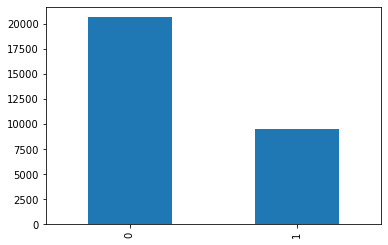

In [ ]:
train_label_df.Target.value_counts().plot(kind='bar')

- This shows that there is the imbalance in the classes, **we need to treat these imbalances** 

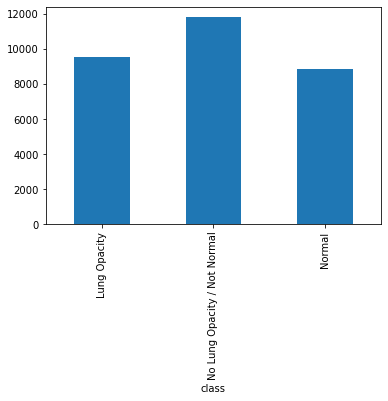

In [ ]:
detailed_class_df.groupby('class').size().plot(kind='bar')

This shows in majority X-Rays there are no lung opacity though but still the XRay is not normal , the patient is suffering from the health issue

Hence for patients whose XRAY does not show opacity but still are not normal, our target label has marked them as 0 because the algorithm can not detect the opacity and show it using the bounding box  

## Combining both Data Frame - Inner Join

In [ ]:
Final_Data = pd.concat([train_label_df, 
                        detailed_class_df.drop('patientId',1)], 1)
print(Final_Data.shape[0], 'combined cases')
Final_Data.sample(3)

30227 combined cases


,patientId,x,y,width,height,Target,class
6080,4bf59f74-040e-470f-a269-2b37e54a79c7,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
28594,fce56107-c115-4cb6-b340-19f87b757035,149.0,256.0,163.0,193.0,1,Lung Opacity
20833,bda1d8b6-2a74-41c3-8cef-3ff7864e4613,205.0,443.0,240.0,295.0,1,Lung Opacity


In [ ]:
Final_Data.isna().sum()

patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
class            0
dtype: int64

In [ ]:
for i in ['x','y','width','height']:
    Final_Data[i].replace(np.NAN,0,inplace=True)

In [ ]:
Final_Data.head(3)

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal


In [ ]:
box_df = Final_Data.groupby('patientId').size().reset_index(name='boxes')
box_df

,patientId,boxes
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,1
1,000924cf-0f8d-42bd-9158-1af53881a557,1
2,000db696-cf54-4385-b10b-6b16fbb3f985,2
3,000fe35a-2649-43d4-b027-e67796d412e0,2
4,001031d9-f904-4a23-b3e5-2c088acd19c6,2
...,...,...
26679,fffb2395-8edd-4954-8a89-ffe2fd329be3,2
26680,fffba05a-1635-4545-9bbd-57ad4cfe8d27,1
26681,fffc95b5-605b-4226-80ab-62caec682b22,1
26682,fffcff11-d018-4414-971a-a7cefa327795,1


In [ ]:
Final_Data = pd.merge(Final_Data, box_df, on='patientId')

In [ ]:
Final_Data.shape

(30227, 8)

In [ ]:
Final_Data.head()

,patientId,x,y,width,height,Target,class,boxes
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,1
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,1
2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,1
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0,Normal,1
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,2


In [ ]:
box_df.groupby('boxes').size().reset_index(name='patients')

,boxes,patients
0,1,23286
1,2,3266
2,3,119
3,4,13


- There are 23286 patients with 1 bounding box , i.e majority of patients have 1 bounding box . But we want to know that patients having boxes are they having the underlying problem or not ? This 23286 number number does not match to number of patients having pneumonia , Hence we need to go in depth and identify the actual scenario

In [ ]:
Tbox_df = Final_Data.groupby(['patientId','Target']).size().reset_index(name='boxes')
Tbox_df

,patientId,Target,boxes
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0,1
1,000924cf-0f8d-42bd-9158-1af53881a557,0,1
2,000db696-cf54-4385-b10b-6b16fbb3f985,1,2
3,000fe35a-2649-43d4-b027-e67796d412e0,1,2
4,001031d9-f904-4a23-b3e5-2c088acd19c6,1,2
...,...,...,...
26679,fffb2395-8edd-4954-8a89-ffe2fd329be3,1,2
26680,fffba05a-1635-4545-9bbd-57ad4cfe8d27,0,1
26681,fffc95b5-605b-4226-80ab-62caec682b22,0,1
26682,fffcff11-d018-4414-971a-a7cefa327795,0,1


In [ ]:
Tbox_df.groupby(['boxes','Target']).size().reset_index(name='patients')

,boxes,Target,patients
0,1,0,20672
1,1,1,2614
2,2,1,3266
3,3,1,119
4,4,1,13


- Now here you see out of 23286 patients there are 2614 patients only who have the underlying problem, 20672 patients do not have and they do not also have bounding box , there coordinates are just marked 0 , i.e why it is being shown as 1 bounding box 

In [ ]:
Final_Data.groupby(['class', 'Target']).size().reset_index(name='Patient Count')

,class,Target,Patient Count
0,Lung Opacity,1,9555
1,No Lung Opacity / Not Normal,0,11821
2,Normal,0,8851


In [ ]:
path=os.getcwd()+'\\'+'stage_2_train_images\\'

In [ ]:
patientID=set(Final_Data.patientId)

In [ ]:
pid=list(patientID)

In [ ]:
id=[]
for i in range(len(patientID)):
    id.append(path+pid[i]+'.dcm')

In [ ]:
image_df=pd.DataFrame([patientID,id])
image_df=image_df.T
image_df.columns=['patientId','Path']
box_pat_ids = set(Final_Data['patientId'].values.tolist())
assert patientID.union(box_pat_ids)==patientID

In [ ]:
Final_Data_df= pd.merge(Final_Data, 
                         image_df, 
                         on='patientId',
                        how='left').sort_values('patientId')
print(Final_Data_df.shape[0], 'image bounding boxes')
Final_Data_df.head(5)

30227 image bounding boxes


,patientId,x,y,width,height,Target,class,boxes,Path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,1,C:\Users\Skillup 08\Desktop\Capstone_Greatlear...
28989,000924cf-0f8d-42bd-9158-1af53881a557,0.0,0.0,0.0,0.0,0,Normal,1,C:\Users\Skillup 08\Desktop\Capstone_Greatlear...
28990,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,Lung Opacity,2,C:\Users\Skillup 08\Desktop\Capstone_Greatlear...
28991,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1,Lung Opacity,2,C:\Users\Skillup 08\Desktop\Capstone_Greatlear...
28992,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1,Lung Opacity,2,C:\Users\Skillup 08\Desktop\Capstone_Greatlear...


In [ ]:
DCM_TAG = ['PatientAge', 'BodyPartExamined', 'ViewPosition', 'PatientSex']
def get_tags(in_path):
    c_dicom = pydicom.read_file(in_path, stop_before_pixels=False)
    tag_dict = {c_tag: getattr(c_dicom, c_tag, '') 
         for c_tag in DCM_TAG}
    tag_dict['path'] = in_path
    return pd.Series(tag_dict)

In [ ]:
image_meta_df = image_df.apply(lambda x: get_tags(x['Path']), 1)

In [ ]:
patient=[]
for i in image_meta_df.path:
    patient.append(i.split('\\')[-1].split('.')[0])

In [ ]:
image_meta_df['patientId']=patient

In [ ]:
image_meta_df.head()

,PatientAge,BodyPartExamined,ViewPosition,PatientSex,path,patientId
0,45,CHEST,AP,M,C:\Users\Skillup 08\Desktop\Capstone_Greatlear...,64c64cdd-19c4-43a8-8220-677e133d7864
1,59,CHEST,PA,F,C:\Users\Skillup 08\Desktop\Capstone_Greatlear...,168bda75-e466-4f06-bc91-5bb163130f79
2,45,CHEST,AP,M,C:\Users\Skillup 08\Desktop\Capstone_Greatlear...,6b013c90-ec73-4a7a-a607-17540c493e0f
3,54,CHEST,PA,F,C:\Users\Skillup 08\Desktop\Capstone_Greatlear...,f47ff61f-e517-455a-9e14-2e8daf40ddc6
4,58,CHEST,AP,M,C:\Users\Skillup 08\Desktop\Capstone_Greatlear...,d9cdb986-5023-4bfe-a249-719072107933


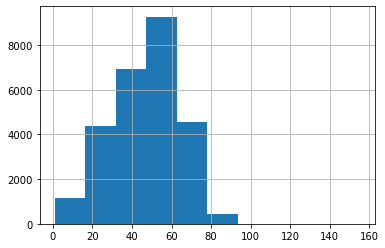

In [ ]:
image_meta_df['PatientAge'] = image_meta_df['PatientAge'].map(int)
image_meta_df['PatientAge'].hist()

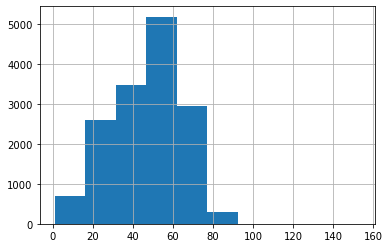

In [ ]:
image_meta_df['PatientAge'][image_meta_df.PatientSex=='M'].hist()

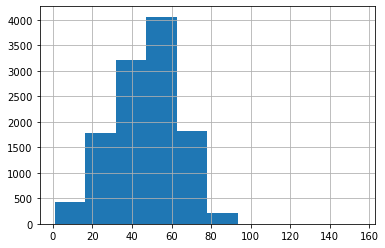

In [ ]:
image_meta_df['PatientAge'][image_meta_df.PatientSex=='F'].hist()

- We can see that patients in majority we of age between 35-65

- When we split it on basis of Gender we found out that for females majority lies between 35 - 65, whereas for males its between 45-65

- We can also see that there is an empty gap after age of 99, there seems to be potential outliers, hence we need to address them 

In [ ]:
def outlier(col):
    IQR=image_meta_df[col].quantile(.75)-image_meta_df[col].quantile(.25)
    upper_bound=image_meta_df[col].quantile(.75) + ( 1.5 * IQR)
    lower_bound=image_meta_df[col].quantile(.25) - ( 1.5 * IQR)
    image_meta_df[col].clip(lower=lower_bound,upper=upper_bound,inplace=True)

{'whiskers': [<matplotlib.lines.Line2D at 0x1c941c454c8>,
 'caps': [<matplotlib.lines.Line2D at 0x1c941c37408>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c941c45d08>],
 'medians': [<matplotlib.lines.Line2D at 0x1c941c3dd88>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c941c3d4c8>],
 'means': []}

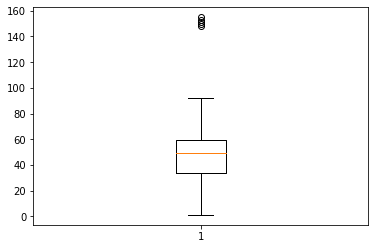

In [ ]:
plt.boxplot(image_meta_df.PatientAge)

In [ ]:
outlier('PatientAge')

{'whiskers': [<matplotlib.lines.Line2D at 0x1c941b9b808>,
 'caps': [<matplotlib.lines.Line2D at 0x1c941b97c08>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c941ba0148>],
 'medians': [<matplotlib.lines.Line2D at 0x1c941b8cf08>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c941b8ca88>],
 'means': []}

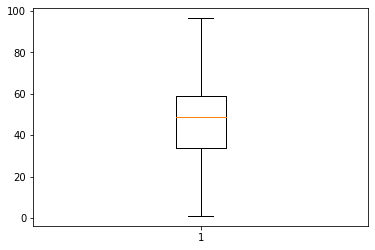

In [ ]:
plt.boxplot(image_meta_df.PatientAge)

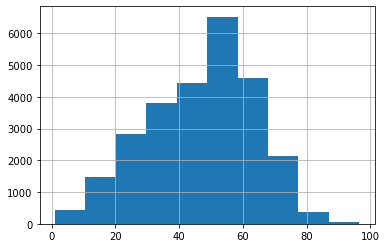

In [ ]:
image_meta_df['PatientAge'].hist()

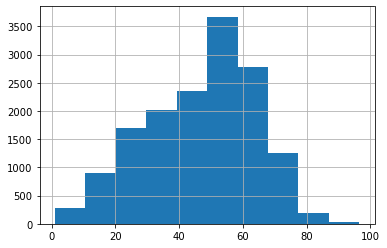

In [ ]:
image_meta_df['PatientAge'][image_meta_df.PatientSex=='M'].hist()

In [ ]:
print('Mean Age of Male',image_meta_df['PatientAge'][image_meta_df.PatientSex=='M'].mean())
print('Mean Age of Female',image_meta_df['PatientAge'][image_meta_df.PatientSex=='F'].mean())

Mean Age of Male 46.991197415271
Mean Age of Female 47.05730161486369


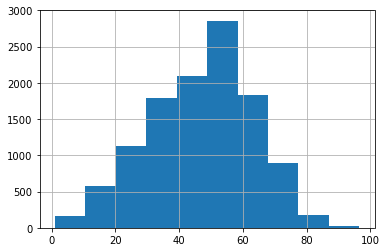

In [ ]:
image_meta_df['PatientAge'][image_meta_df.PatientSex=='F'].hist()

Now you can see that we have removed the outliers 

We can see that patients in majority we of age between 38-75

Post removing outlier, we see the change that  When we split it on basis of Gender, for females majority lies between 38 - 58, whereas for males its between 50-75

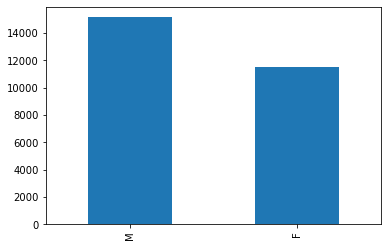

In [ ]:
image_meta_df.PatientSex.value_counts().plot(kind='bar')

In [ ]:
image_meta_df.PatientSex.value_counts()

M    15166
F    11518
Name: PatientSex, dtype: int64

We can see that Males are in majority whose XRays are being conducted , we can say that approximately every 3rd person going for XRAY is Female 

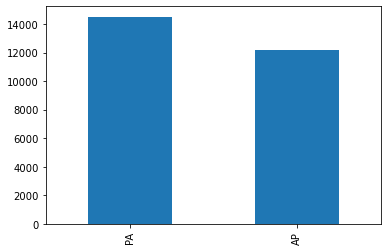

In [ ]:
image_meta_df.ViewPosition.value_counts().plot(kind='bar')

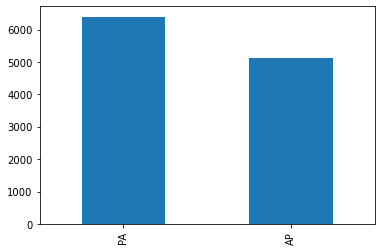

In [ ]:
image_meta_df.ViewPosition[image_meta_df.PatientSex=='F'].value_counts().plot(kind='bar')

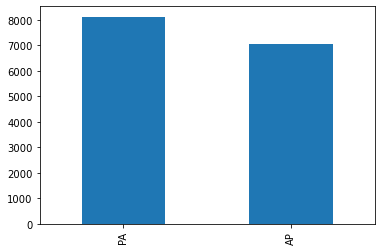

In [ ]:
image_meta_df.ViewPosition[image_meta_df.PatientSex=='M'].value_counts().plot(kind='bar')

- We can see that there is not much difference between **posteroanterior** & **anteroposterior** View Position of X-Rays 

- There is no difference in distribution as such on based on Gender 

In [ ]:
image_meta_df.drop(['path','patientId'],1).describe(exclude=np.number)

,BodyPartExamined,ViewPosition,PatientSex
count,26684,26684,26684
unique,1,2,2
top,CHEST,PA,M
freq,26684,14511,15166


In [ ]:
image_meta_df.head(3)

,PatientAge,BodyPartExamined,ViewPosition,PatientSex,path,patientId
0,45.0,CHEST,AP,M,C:\Users\Skillup 08\Desktop\Capstone_Greatlear...,64c64cdd-19c4-43a8-8220-677e133d7864
1,59.0,CHEST,PA,F,C:\Users\Skillup 08\Desktop\Capstone_Greatlear...,168bda75-e466-4f06-bc91-5bb163130f79
2,45.0,CHEST,AP,M,C:\Users\Skillup 08\Desktop\Capstone_Greatlear...,6b013c90-ec73-4a7a-a607-17540c493e0f


In [ ]:
image_full_df = pd.merge(Final_Data_df,
                         image_meta_df,
                         on='patientId')

In [ ]:
image_full_df.head(3)

,patientId,x,y,width,height,Target,class,boxes,Path,PatientAge,BodyPartExamined,ViewPosition,PatientSex,path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,1,C:\Users\Skillup 08\Desktop\Capstone_Greatlear...,51.0,CHEST,PA,F,C:\Users\Skillup 08\Desktop\Capstone_Greatlear...
1,000924cf-0f8d-42bd-9158-1af53881a557,0.0,0.0,0.0,0.0,0,Normal,1,C:\Users\Skillup 08\Desktop\Capstone_Greatlear...,19.0,CHEST,AP,F,C:\Users\Skillup 08\Desktop\Capstone_Greatlear...
2,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,Lung Opacity,2,C:\Users\Skillup 08\Desktop\Capstone_Greatlear...,25.0,CHEST,AP,F,C:\Users\Skillup 08\Desktop\Capstone_Greatlear...


In [ ]:
sample_df = Final_Data_df.groupby(['Target','class', 'boxes']).apply(lambda x: x[x['patientId']==x.sample(1)['patientId'].values[0]]).reset_index(drop=True)
sample_df

,patientId,x,y,width,height,Target,class,boxes,Path
0,7190f7a7-9e9a-453b-b837-2c7126e11968,0.0,0.0,0.0,0.0,0,No Lung Opacity / Not Normal,1,C:\Users\Skillup 08\Desktop\Capstone_Greatlear...
1,ff7a9337-c12a-45a9-ab7f-3d7ea08e1162,0.0,0.0,0.0,0.0,0,Normal,1,C:\Users\Skillup 08\Desktop\Capstone_Greatlear...
2,a09d65c9-1707-47d4-a241-212aa118a860,630.0,213.0,218.0,523.0,1,Lung Opacity,1,C:\Users\Skillup 08\Desktop\Capstone_Greatlear...
3,31e4e2fe-9d21-4cf9-ba57-3174ebc32a43,712.0,513.0,216.0,254.0,1,Lung Opacity,2,C:\Users\Skillup 08\Desktop\Capstone_Greatlear...
4,31e4e2fe-9d21-4cf9-ba57-3174ebc32a43,442.0,231.0,164.0,363.0,1,Lung Opacity,2,C:\Users\Skillup 08\Desktop\Capstone_Greatlear...
5,1565fd6c-9432-454a-87e4-937fd5ad5b60,267.0,537.0,178.0,235.0,1,Lung Opacity,3,C:\Users\Skillup 08\Desktop\Capstone_Greatlear...
6,1565fd6c-9432-454a-87e4-937fd5ad5b60,655.0,308.0,130.0,138.0,1,Lung Opacity,3,C:\Users\Skillup 08\Desktop\Capstone_Greatlear...
7,1565fd6c-9432-454a-87e4-937fd5ad5b60,159.0,295.0,160.0,184.0,1,Lung Opacity,3,C:\Users\Skillup 08\Desktop\Capstone_Greatlear...
8,0ab261f9-4eb5-42ab-a9a5-e918904d6356,722.0,558.0,88.0,88.0,1,Lung Opacity,4,C:\Users\Skillup 08\Desktop\Capstone_Greatlear...
9,0ab261f9-4eb5-42ab-a9a5-e918904d6356,613.0,352.0,106.0,102.0,1,Lung Opacity,4,C:\Users\Skillup 08\Desktop\Capstone_Greatlear...


In [ ]:
sample_df.shape

(12, 9)

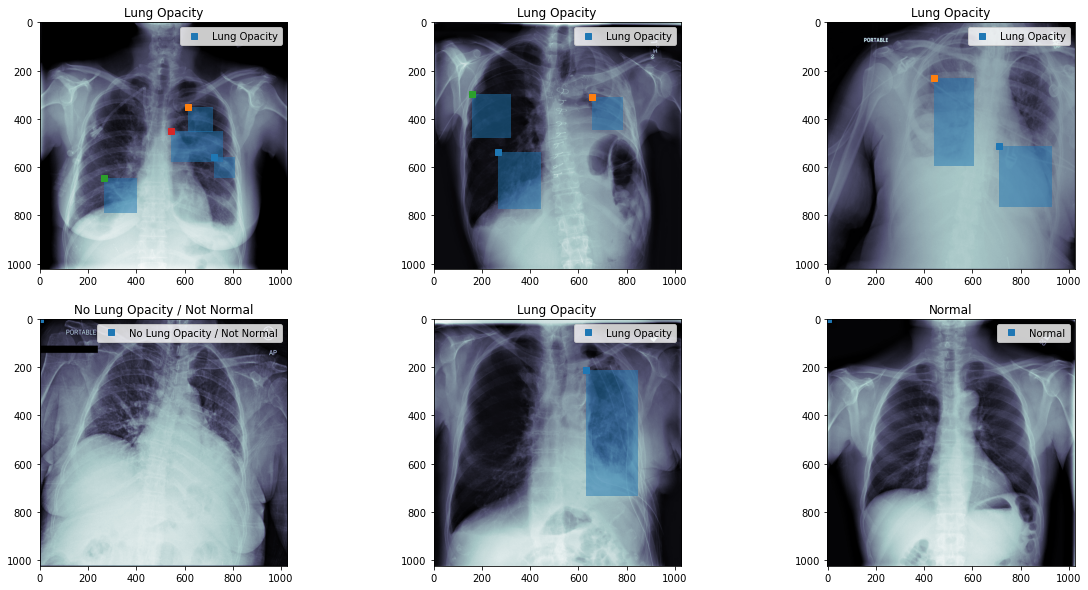

In [ ]:
fig, m_axs = plt.subplots(2, 3, figsize = (20, 10))
for c_ax, (c_path, c_rows) in zip(m_axs.flatten(),sample_df.groupby(['Path'])):
    c_dicom = pydicom.read_file(c_path)
    c_ax.imshow(c_dicom.pixel_array, cmap='bone')
    c_ax.set_title('{class}'.format(**c_rows.iloc[0,:]))
    for i, (_, c_row) in enumerate(c_rows.dropna().iterrows()):
        c_ax.plot(c_row['x'], c_row['y'], 's', label='{class}'.format(**c_row))
        c_ax.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                                width=c_row['width'],
                                height=c_row['height'], 
                                 alpha = 0.5))
        if i==0: c_ax.legend()

## Bounding Box Distribution

### Understanding the x & y coordinates 

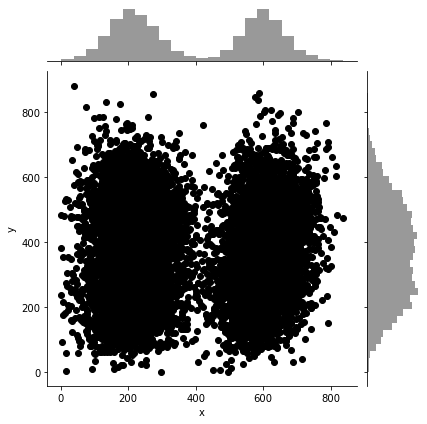

In [ ]:
sns.jointplot(x="x", y="y", data=image_full_df[image_full_df.x >0],color='k')

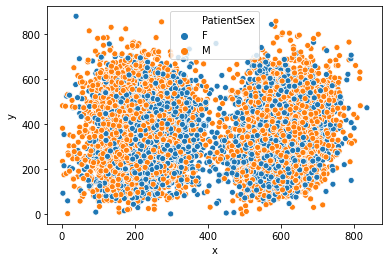

In [ ]:
sns.scatterplot(image_full_df.x[image_full_df.x >0],image_full_df.y[image_full_df.x >0],hue=image_full_df.PatientSex[image_full_df.x >0])

On the basis of gender :

- For Females , in their left lung, opacity is being found in mostly right portion , as you can see the high concentration 

- For Females , in their right lung, opacity is being found in mostly left portion , as you can see the high concentration 

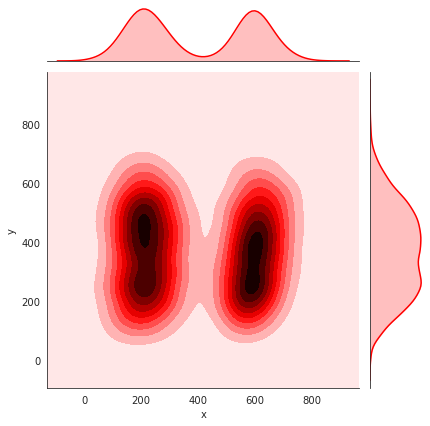

In [ ]:
with sns.axes_style("white"):
    sns.jointplot(x="x", y="y", kind="kde", color="r",data=image_full_df[image_full_df.x >0])

#### Understanding Bounding Box Coordinates for Females

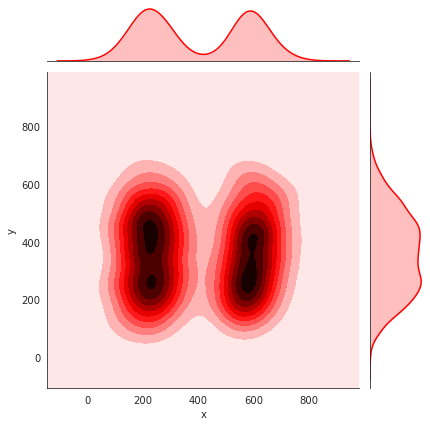

In [ ]:
with sns.axes_style("white"):
    sns.jointplot(x="x", y="y", kind="kde", color="r",data=image_full_df[(image_full_df.x >0) & (image_full_df.PatientSex=='F')])

For Females we can see higher density lies in :

- For Left Lung : Range of Y-coordinate (380-550) & (220-300) & X-coordinate is 200

- For Right Lung : Range of Y-coordinate (200-550) & X-coordinate is 600, though there is slight decrease in density in between Y-Coordinate (380-390)

#### Understanding Bounding Box Coordinates for Males

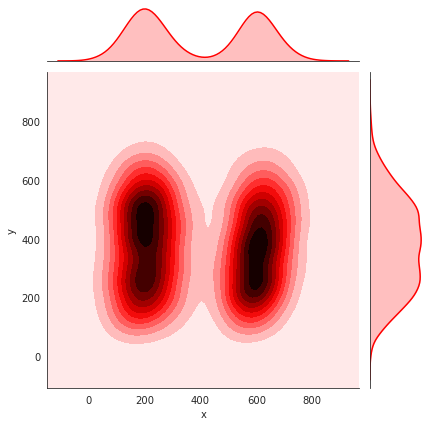

In [ ]:
with sns.axes_style("white"):
    sns.jointplot(x="x", y="y", kind="kde", color="r",data=image_full_df[(image_full_df.x >0) & (image_full_df.PatientSex=='M')])

For Males we can see higher density lies in :

- For Left Lung : Range of between (380,200)&(580,200)

- For Right Lung : Range of Y-coordinate (200,600)(450,600)

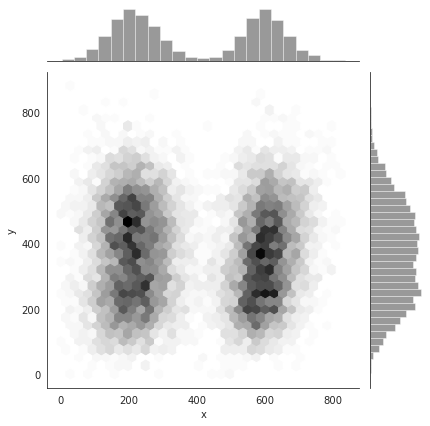

In [ ]:
with sns.axes_style("white"):
    sns.jointplot(x="x", y="y", kind="hex", color="k",data=image_full_df[image_full_df.x >0]);

This above KDE plot is showing two distribution on left and right because of lungs , it is showing distribution of coordinates on each side of lung !

On left lung most of the bounding box lies in between range of (400,200) to (550,200)

On right lung most of the bounding box lies in between range of (200,600) to (400,600) 

We can say that mostly right lung is more affected than left

### Distribution of Height and Width of Bounding Box - understanding the Shape

**Shape Tells us the Level of Opacity. If shape is rectangle i assume that the opacity will be more , whereas if shape is square, I assume the opacity is less !

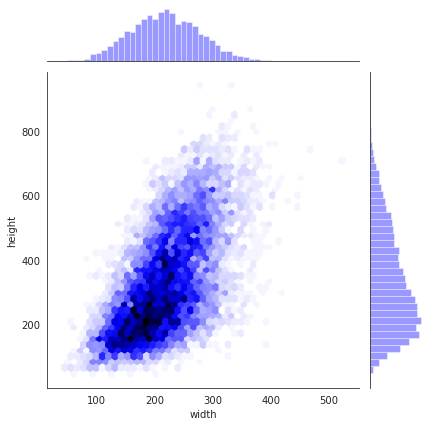

In [ ]:
with sns.axes_style("white"):
    sns.jointplot(x="width", y="height", kind="hex", color="b",data=image_full_df[image_full_df.x >0]);

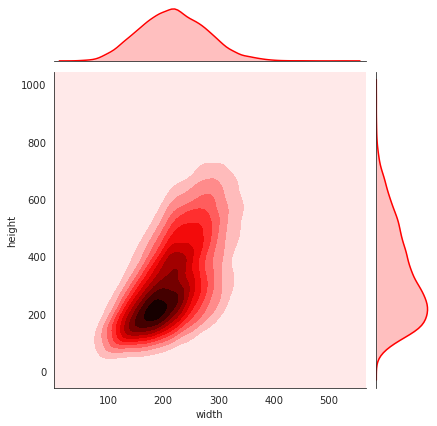

In [ ]:
with sns.axes_style("white"):
    sns.jointplot(x="width", y="height", kind="kde", color="r",data=image_full_df[image_full_df.x >0]);

#### Understanding Bounding Box Shape for Males

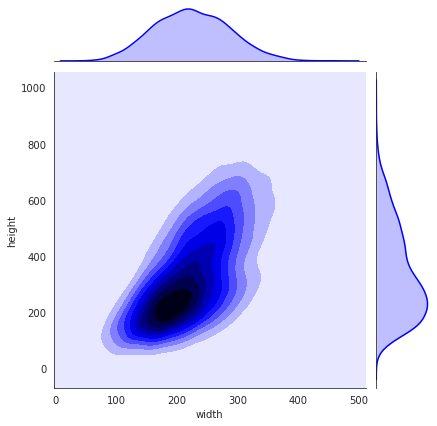

In [ ]:
with sns.axes_style("white"):
    sns.jointplot(x="width", y="height",kind='kde', color="b",data=image_full_df[(image_full_df.x >0) & (image_full_df.PatientSex=='M')]);

For Males we see that most of the boxes are squarish , high density can be seen at around ( 200,200)

There is only a single concentration in that area 

#### Understanding Bounding Box Shape for Females

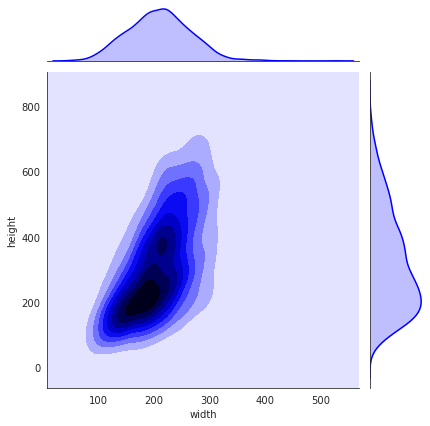

In [ ]:
with sns.axes_style("white"):
    sns.jointplot(x="width", y="height",kind='kde', color="b",data=image_full_df[(image_full_df.x >0) & (image_full_df.PatientSex=='F')]);

For Female there are two cluster forming of concentration , highest concentration is at (200,200) and the smaller concentration is there at (400,210)

### Understanding Pneumonia Location

Text(0.5, 1.01, 'Pneumonia location')

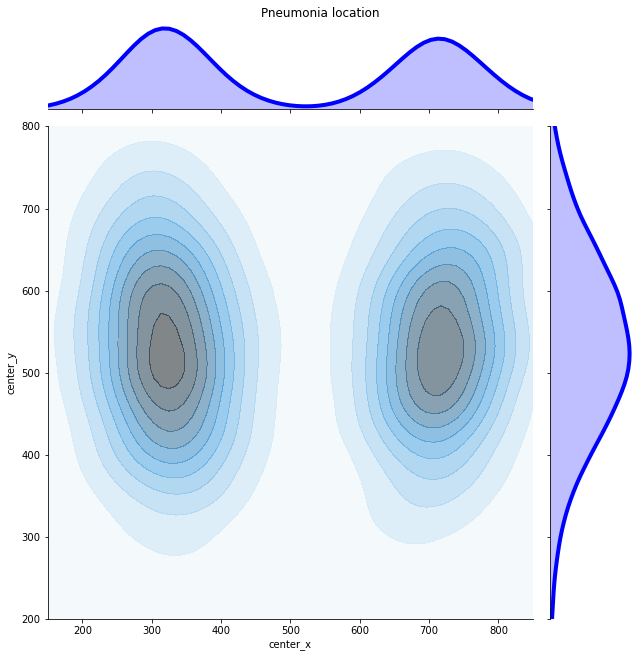

In [ ]:
centers = (image_full_df[image_full_df.x>0]).assign(center_x= image_full_df.x[image_full_df.x>0] + image_full_df.width[image_full_df.x>0] / 2, center_y=image_full_df.y[image_full_df.y>0] + image_full_df.height[image_full_df.y>0] / 2)

ax = sns.jointplot("center_x", "center_y", data=centers, height=9, alpha=0.5,xlim=(150,850), ylim=(200,800), kind='kde',marginal_kws={'lw':4,'color':'blue'})
ax.fig.suptitle("Pneumonia location", y=1.01)

- We notice that higher chances of opacity to be identified is in between :

- in left lung : (580,320) & (480,320)

- in right lung : (590,700) & (460,700)

#### Understanding Pneumonia Location for Males

Text(0.5, 1.01, 'Pneumonia location')

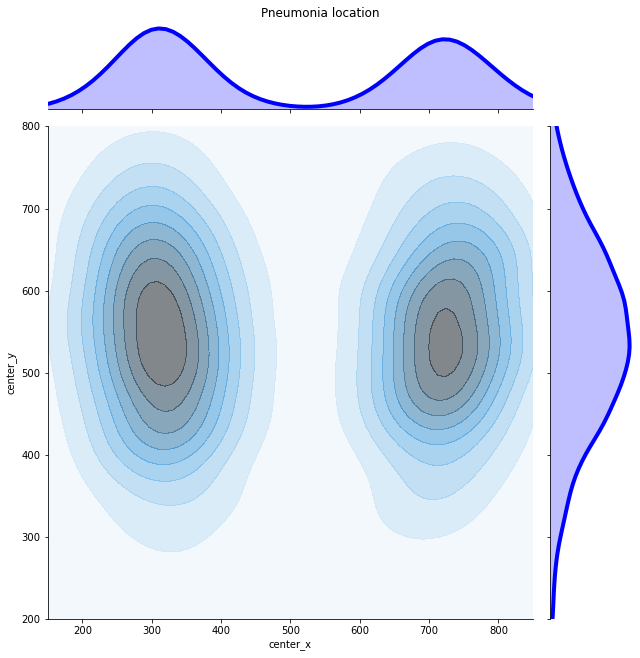

In [ ]:
centers = (image_full_df[(image_full_df.x>0)&(image_full_df.PatientSex=='M')]).assign(center_x= image_full_df.x[(image_full_df.x>0)&(image_full_df.PatientSex=='M')] + image_full_df.width[(image_full_df.x>0)&(image_full_df.PatientSex=='M')] / 2, center_y=image_full_df.y[(image_full_df.x>0)&(image_full_df.PatientSex=='M')] + image_full_df.height[(image_full_df.x>0)&(image_full_df.PatientSex=='M')] / 2)

ax = sns.jointplot("center_x", "center_y", data=centers, height=9, alpha=0.5,xlim=(150,850), ylim=(200,800), kind='kde',marginal_kws={'lw':4,'color':'blue'})
ax.fig.suptitle("Pneumonia location", y=1.01)

- We notice for Male, there are higher chances of opacity to be identified is in between :

- in left lung : (600,320) & (460,320)

- in right lung : (570,700) & (500,700)

#### Understanding Pneumonia Location for Females

Text(0.5, 1.01, 'Pneumonia location')

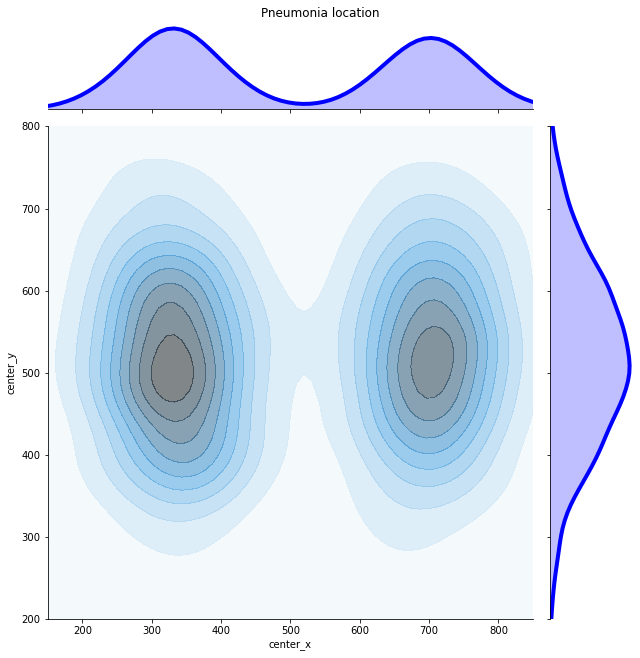

In [ ]:
centers = (image_full_df[(image_full_df.x>0)&(image_full_df.PatientSex=='F')]).assign(center_x= image_full_df.x[(image_full_df.x>0)&(image_full_df.PatientSex=='F')] + image_full_df.width[(image_full_df.x>0)&(image_full_df.PatientSex=='F')] / 2, center_y=image_full_df.y[(image_full_df.x>0)&(image_full_df.PatientSex=='F')] + image_full_df.height[(image_full_df.x>0)&(image_full_df.PatientSex=='F')] / 2)

ax = sns.jointplot("center_x", "center_y", data=centers, height=9, alpha=0.5,xlim=(150,850), ylim=(200,800), kind='kde',marginal_kws={'lw':4,'color':'blue'})
ax.fig.suptitle("Pneumonia location", y=1.01)

- We notice for Male, there are higher chances of opacity to be identified is in between :

- in left lung : (550,320) & (450,320)

- in right lung : (550,700) & (450,700)

### Lets focun on the age group between 40 to 65

In [ ]:
img_data=image_full_df[(image_full_df.PatientAge>39) & (image_full_df.PatientAge<66)]

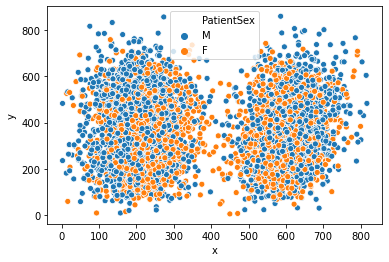

In [ ]:
sns.scatterplot(img_data.x[img_data.x >0],img_data.y[img_data.x >0],hue=img_data.PatientSex[img_data.x >0])

- Females in age between 40 to 60 have higher concentration of opacity on :

    - Left Lung : Higher concentration in left side , hence opacity is found in left side of the left lung
    
    - Right Lung : Higher concentration is on the right side.

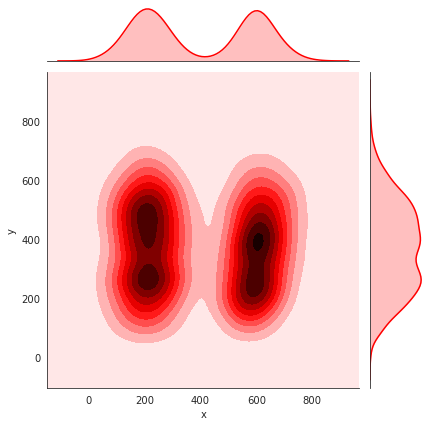

In [ ]:
with sns.axes_style("white"):
    sns.jointplot(x="x", y="y", kind="kde", color="r",data=img_data[img_data.x >0])

For patients in age group between 45 to 65

- The prominent density is shown in the right lung between coordinates (390,600) to (410,600)

- Though there are formidible 2 clusters in left lung first is in between (220,200) to (300,200) and second cluster is (380,570)

#### Understanding Bounding Box Coordinates for Females

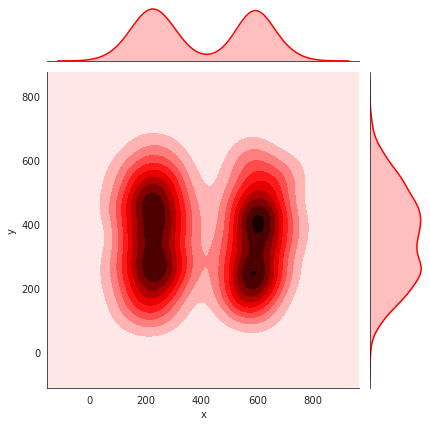

In [ ]:
with sns.axes_style("white"):
    sns.jointplot(x="x", y="y", kind="kde", color="r",data=img_data[(img_data.x >0) & (img_data.PatientSex=='F')])

For female patients in age group between 45 to 65

- There are two cluster of prominent density in the right lung between, First Cluster:  coordinates (210,600) to (220,600) & Second Cluster (380,600) to ( 440 ,600)



#### Understanding Bounding Box Coordinates for Males

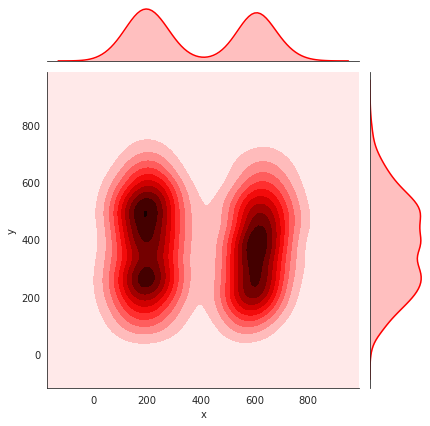

In [ ]:
with sns.axes_style("white"):
    sns.jointplot(x="x", y="y", kind="kde", color="r",data=img_data[(img_data.x >0) & (img_data.PatientSex=='M')])

For male patients in age group between 45 to 65

- There is only one prominent density cluster seen in left lung around ( 500,200) to (505,200)



#### Distribution of Height and Width of Bounding Box - understanding the Shape for age group 40 to 65

**Shape Tells us the Level of Opacity. If shape is rectangle i assume that the opacity will be more , whereas if shape is square, I assume the opacity is less !

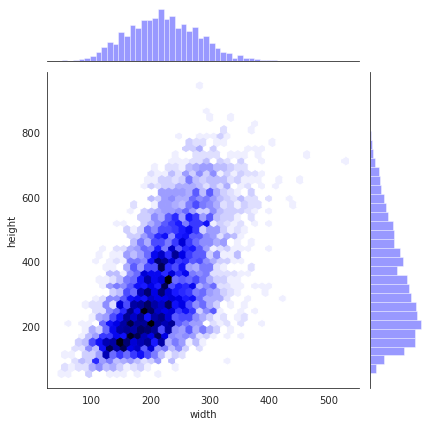

In [ ]:
with sns.axes_style("white"):
    sns.jointplot(x="width", y="height", kind="hex", color="b",data=img_data[img_data.x >0]);

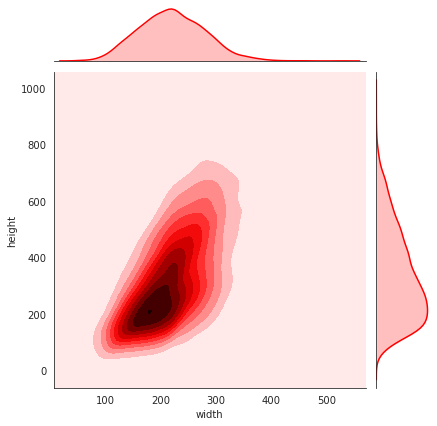

In [ ]:
with sns.axes_style("white"):
    sns.jointplot(x="width", y="height", kind="kde", color="r",data=img_data[img_data.x >0]);

#### Understanding Bounding Box Shape for Males

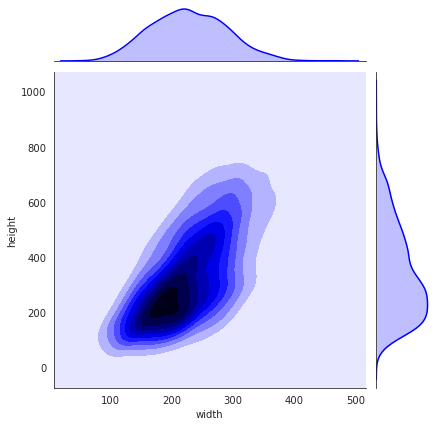

In [ ]:
with sns.axes_style("white"):
    sns.jointplot(x="width", y="height",kind='kde', color="b",data=img_data[(img_data.x >0) & (img_data.PatientSex=='M')]);

For Males we see that most of the boxes are squarish , high density can be seen between ( 250,200) & (180, 180)

There is only a single concentration in that area 

#### Understanding Bounding Box Shape for Females

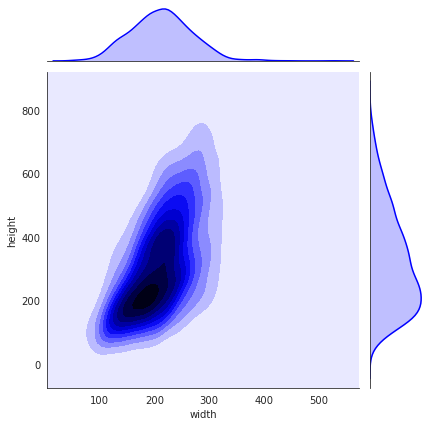

In [ ]:
with sns.axes_style("white"):
    sns.jointplot(x="width", y="height",kind='kde', color="b",data=img_data[(img_data.x >0) & (img_data.PatientSex=='F')]);

For Female there are two cluster forming of concentration , highest concentration is between (180,120) and (25,210)

### Understanding Pneumonia Location

Text(0.5, 1.01, 'Pneumonia location')

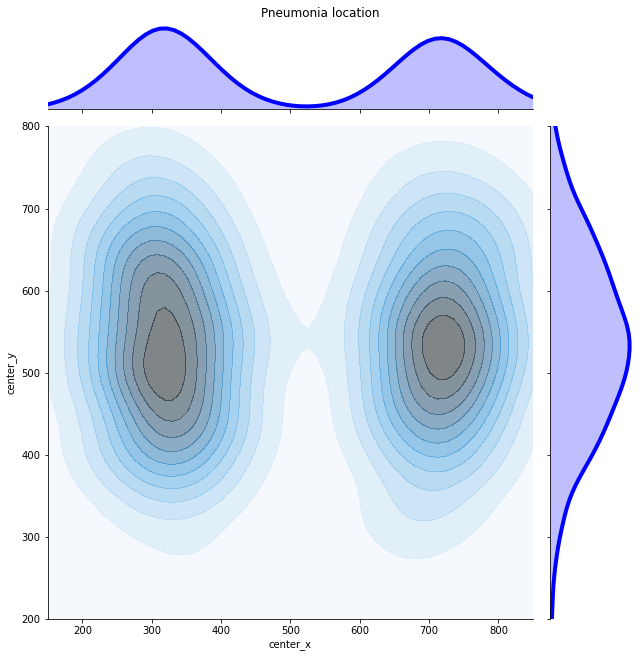

In [ ]:
centers = (img_data[img_data.x>0]).assign(center_x= img_data.x[img_data.x>0] + img_data.width[img_data.x>0] / 2, center_y=img_data.y[img_data.y>0] + img_data.height[img_data.y>0] / 2)

ax = sns.jointplot("center_x", "center_y", data=centers, height=9, alpha=0.5,xlim=(150,850), ylim=(200,800), kind='kde',marginal_kws={'lw':4,'color':'blue'})
ax.fig.suptitle("Pneumonia location", y=1.01)

- We notice that higher chances of opacity to be identified is in between :

- in left lung : (580,320) & (460,320)

- in right lung : (560,700) & (500,700)

#### Understanding Pneumonia Location for Males

Text(0.5, 1.01, 'Pneumonia location')

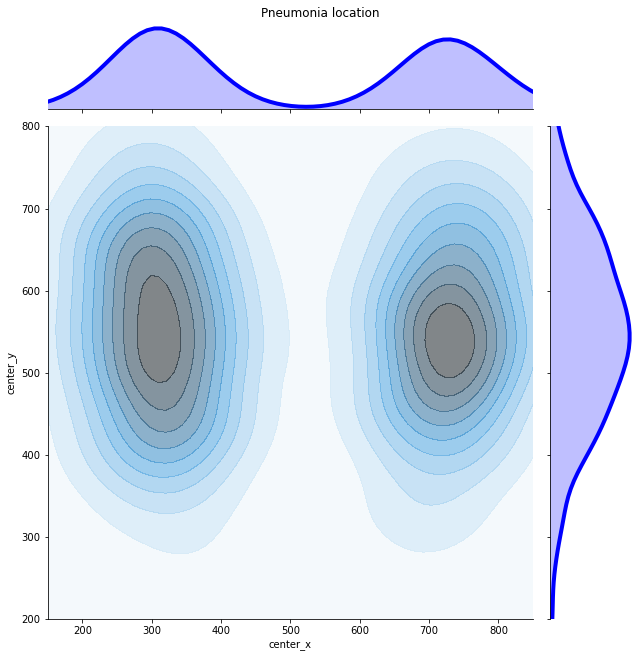

In [ ]:
centers = (img_data[(img_data.x>0)&(img_data.PatientSex=='M')]).assign(center_x= img_data.x[(img_data.x>0)&(img_data.PatientSex=='M')] + img_data.width[(img_data.x>0)&(img_data.PatientSex=='M')] / 2, center_y=img_data.y[(img_data.x>0)&(img_data.PatientSex=='M')] + img_data.height[(img_data.x>0)&(img_data.PatientSex=='M')] / 2)

ax = sns.jointplot("center_x", "center_y", data=centers, height=9, alpha=0.5,xlim=(150,850), ylim=(200,800), kind='kde',marginal_kws={'lw':4,'color':'blue'})
ax.fig.suptitle("Pneumonia location", y=1.01)

- We notice for Male, there are higher chances of opacity to be identified is in between :

- in left lung : (620,320) & (480,320)

- in right lung : (570,700) & (500,700)

#### Understanding Pneumonia Location for Females

Text(0.5, 1.01, 'Pneumonia location')

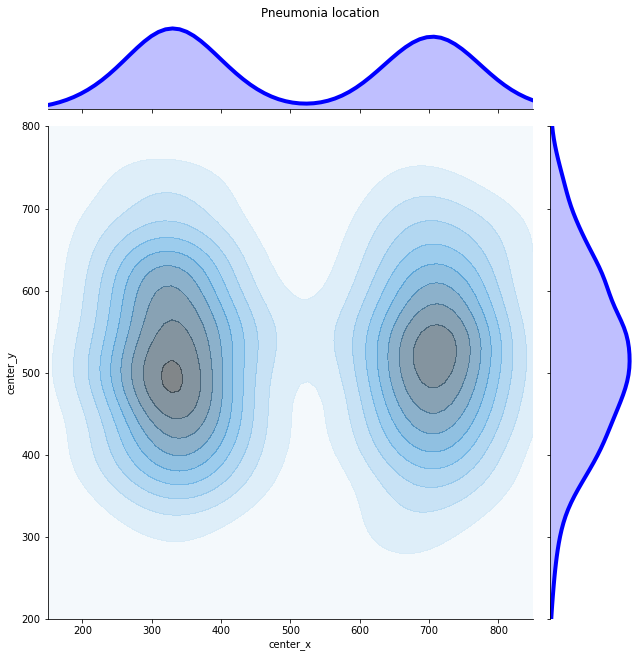

In [ ]:
centers = (img_data[(img_data.x>0)&(img_data.PatientSex=='F')]).assign(center_x= img_data.x[(img_data.x>0)&(img_data.PatientSex=='F')] + img_data.width[(img_data.x>0)&(img_data.PatientSex=='F')] / 2, center_y=img_data.y[(img_data.x>0)&(img_data.PatientSex=='F')] + img_data.height[(img_data.x>0)&(img_data.PatientSex=='F')] / 2)

ax = sns.jointplot("center_x", "center_y", data=centers, height=9, alpha=0.5,xlim=(150,850), ylim=(200,800), kind='kde',marginal_kws={'lw':4,'color':'blue'})
ax.fig.suptitle("Pneumonia location", y=1.01)

- We notice for female, there are higher chances of opacity to be identified is in between :

- in left lung : (500,320) & (480,320)

- in right lung : (550,700) & (490,700)

# Data Prepration for Modeling

### Subsetting Useful Columns from image_full_df dataframe

In [ ]:
sub_img_data=image_full_df[['patientId','x','y','width','height','Target','path']].copy()

In [ ]:
sub_img_data['image_name']=sub_img_data.patientId + '.png'

## Changing dicom to png

In [ ]:
out=os.getcwd() +'\\' + 'train_images' + '\\'
inputdir=os.getcwd()+ '\\' + 'stage_2_train_images' + '\\'
test_list = [os.path.basename(x) for x in glob.glob(inputdir + '.\*.dcm')]
for f in test_list:   
    ds = pydicom.read_file(inputdir + f) # read dicom image
    img = ds.pixel_array # get image array
    cv2.imwrite(out + f.replace('.dcm','.png'),img) # write png image

### Defining path for PNG Image Folder

In [ ]:
Paths=os.getcwd()+ '\\'+'train_images'+'\\'

### Defining Image Paths in png_path variable 

In [ ]:
sub_img_data['png_path']=Paths+sub_img_data.image_name

### Prepration of Bounding Box Coordinates

In [ ]:
sub_img_data.rename(columns={'x':'xmin','y':'ymin'},inplace=True)

In [ ]:
sub_img_data['xmax']=sub_img_data.xmin + sub_img_data.width
sub_img_data['ymax']=sub_img_data.ymin + sub_img_data.height

### Final Prepared Data 

In [ ]:
sub_data=sub_img_data[['png_path','xmin','xmax','ymin','ymax','Target']]

In [ ]:
sub_data.to_csv('sub_data.csv')
image_full_df.to_csv('image_full_df.csv')


In [ ]:
sub_data.head()

,png_path,xmin,xmax,ymin,ymax,Target
0,C:\Users\Skillup 08\Desktop\Capstone_Greatlear...,0,0,0,0,0
1,C:\Users\Skillup 08\Desktop\Capstone_Greatlear...,0,0,0,0,0
2,C:\Users\Skillup 08\Desktop\Capstone_Greatlear...,316,486,318,796,1
3,C:\Users\Skillup 08\Desktop\Capstone_Greatlear...,660,806,375,777,1
4,C:\Users\Skillup 08\Desktop\Capstone_Greatlear...,570,839,282,691,1


### Splitting Data in Train and Validation Data

In [ ]:
#train_X,val_X=tts(sub_data,test_size=.30,random_state=1)
train_X=pd.read_csv('train.csv')
val_X=pd.read_csv('val.csv')

## Image Data Generator

In [ ]:
#msk= np.zeros(img.shape)
class DataSequence(keras.utils.Sequence):

    def __init__(self, data):
        self.paths = []
        #self.mask=[]
        #self.msk= np.zeros(img.shape)
        self.coords=np.zeros((data.shape[0],4))
        for index,row in data.iterrows():
            for i,r in enumerate(row[1:5]):
                row[i+1]=int(r)
            path,xmin,xmax,ymin,ymax,_=row
            #msk[ymin:ymax,xmin:xmax]=1
            #self.mask.append(msk)
            self.coords[index,0]=xmin/IMAGE_SIZE
            self.coords[index,1]=ymin/IMAGE_SIZE
            self.coords[index,2]=xmax/IMAGE_SIZE
            self.coords[index,3]=ymax/IMAGE_SIZE
            self.paths.append(path)
        

        
    def __len__(self):
        return math.ceil(len(self.coords) / BATCH_SIZE)

    def __getitem__(self, idx): # Get a batch
        batch_paths = self.paths[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE] # Image path
        batch_coords = self.coords[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE] # Image coords

        batch_images = np.zeros((len(batch_paths), IMAGE_SIZE, IMAGE_SIZE,1), dtype=np.float32)
        for i, f in enumerate(batch_paths):
            img = Image.open(f) # Read image
            img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
            #img = img.convert('RGB')
            img = np.expand_dims(img, -1)

            batch_images[i] = preprocess_input(np.array(img, dtype=np.float32)) # Convert to float32 array
            #img.close()

        return batch_images, batch_coords

In [ ]:
class Validation(Callback):
    def __init__(self, generator):
        self.generator = generator

    def on_epoch_end(self, epoch, logs):
        intersections = 0
        unions = 0

        for i in range(len(self.generator)):
            batch_images, gt = self.generator[i] # Get batch
            pred = self.model.predict_on_batch(batch_images) # Predict bbox on batch

            # Compute interection of predicted (pred) and ground truth (gt) bounding boxes
            diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
            diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
            intersection = diff_width * diff_height

            # Compute union
            area_gt = gt[:,2] * gt[:,3]
            area_pred = pred[:,2] * pred[:,3]
            union = area_gt + area_pred - intersection

            # Compute intersection and union over multiple boxes
            for j, _ in enumerate(union):
                if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
                    intersections += intersection[j]
                    unions += union[j]

        # Compute IOU. Use epsilon to prevent division by zero
        iou = np.round(intersections / (unions + epsilon()), 4)
        logs["val_iou"] = iou

        print(" - val_iou: {}".format(iou))

### Defining Loss Function

In [ ]:
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

### Model Parameters

In [ ]:

IMAGE_SIZE = 128 # Image sizes can vary (128, 160, 192, 224)

EPOCHS = 5 
BATCH_SIZE = 32 
PATIENCE = 10 # Patience for early stopping

MULTI_PROCESSING = False 
THREADS = 1 


### Initializing Data Generator

In [ ]:
train_datagen = DataSequence(train_X)
val_data=Validation(generator=DataSequence(val_X))

## Model 1

In [ ]:
def downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.99)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(3)(x)
    return x

def resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.99)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.99)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = downsample(channels, x)
        for b in range(n_blocks):
            x = resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization(momentum=0.99)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(4,(5,5), 1)(x)
    
    x = keras.layers.Conv2D(4,(3,3), 2)(x)
    x = keras.layers.MaxPooling2D((3,3),strides=(2,2))(x)
    
    #outputs = keras.layers.UpSampling2D(2**depth)(x)
    x = Reshape((4,))(x) 
    model = keras.Model(inputs=inputs, outputs=x)
    return model


In [ ]:
model = create_network(input_size=128, channels=6, n_blocks=2, depth=2)

In [ ]:
model.summary()

Model: "model_116"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_135 (InputLayer)          [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_2020 (Conv2D)            (None, 128, 128, 6)  54          input_135[0][0]                  
__________________________________________________________________________________________________
batch_normalization_1182 (Batch (None, 128, 128, 6)  24          conv2d_2020[0][0]                
__________________________________________________________________________________________________
leaky_re_lu_869 (LeakyReLU)     (None, 128, 128, 6)  0           batch_normalization_1182[0][0]   
__________________________________________________________________________________________

In [ ]:
model.compile(loss='mean_squared_error', optimizer="adam", metrics=[]) # Regression loss is MSE

checkpoint = ModelCheckpoint("model-{val_iou:.2f}.h5", monitor="val_iou", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max") # Stop early, if the validation error deteriorates
reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")
# Reduce learning rate if Validation IOU does not improve

history=model.fit_generator(generator=train_datagen,
                    epochs=EPOCHS,
                    callbacks=[val_data, checkpoint, reduce_lr, stop],
                    workers=THREADS,
                    use_multiprocessing=MULTI_PROCESSING,
                    shuffle=True,
                    verbose=1)

Epoch 1/5
661/662 [============================>.] - ETA: 1s - loss: 3.4269 - val_iou: 0.17030000686645508

Epoch 00001: val_iou improved from -inf to 0.17030, saving model to model-0.17.h5
662/662 [==============================] - 1450s 2s/step - loss: 3.4280
Epoch 2/5
661/662 [============================>.] - ETA: 1s - loss: 3.1387 - val_iou: 0.2020999938249588

Epoch 00002: val_iou improved from 0.17030 to 0.20210, saving model to model-0.20.h5
662/662 [==============================] - 1272s 2s/step - loss: 3.1380
Epoch 3/5
661/662 [============================>.] - ETA: 1s - loss: 3.0015 - val_iou: 0.2224999964237213

Epoch 00003: val_iou improved from 0.20210 to 0.22250, saving model to model-0.22.h5
662/662 [==============================] - 1207s 2s/step - loss: 3.0006
Epoch 4/5
661/662 [============================>.] - ETA: 1s - loss: 2.9298 - val_iou: 0.1915999948978424

Epoch 00004: val_iou did not improve from 0.22250
662/662 [==============================] - 1206s 2s/s

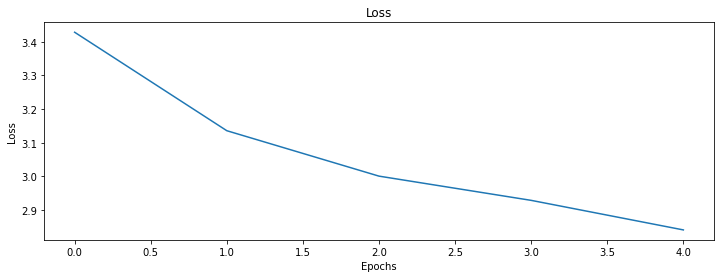

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

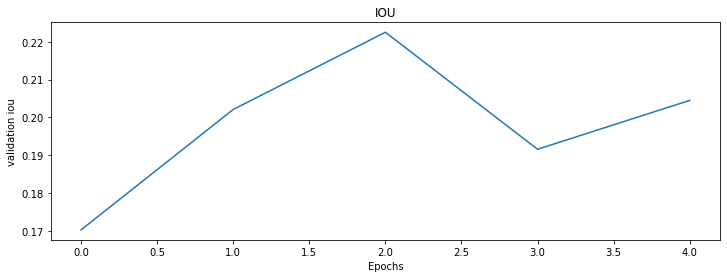

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(history.epoch, history.history["val_iou"])
plt.title('IOU')
plt.xlabel("Epochs")
plt.ylabel("validation iou")
plt.show()

## Model 2 - On VGG Architecture

<img src='https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/02/Plot-of-Convolutional-Neural-Network-Architecture-with-Multiple-VGG-Blocks-440x1024.png'>

In [ ]:
def vgg_block(layer_in, n_filters, n_conv):
    for _ in range(n_conv):
        layer_in = keras.layers.Conv2D(n_filters, (3,3), padding='same', activation='relu')(layer_in)
    # add max pooling layer
    layer_in = keras.layers.MaxPooling2D((2,2), strides=(2,2))(layer_in)
    return layer_in
 
# define model input


In [ ]:
visible = keras.layers.Input(shape=(128, 128, 1))
# add vgg module
layer = vgg_block(visible, 3, 2)
layer = vgg_block(layer, 6, 2)
#layer=keras.layers.BatchNormalization(momentum=0.99)(layer)
layer = vgg_block(layer, 12, 2)
#layer=keras.layers.Dropout(.2)(layer)
#layer=Conv2D(6,(1,1),activation='relu')(layer)
layer = vgg_block(layer, 18, 3)
#layer=keras.layers.BatchNormalization(momentum=0.99)(layer)
layer = vgg_block(layer, 24, 3)
layer=Conv2D(24, (3,3), padding='same', activation='relu')(layer)
layer=Conv2D(4,(1,1))(layer)
layer=Conv2D(4, (3,3), padding='same', activation='relu')(layer)
#layer=keras.layers.MaxPooling2D((3,3),strides=(2,2))(layer)
layer=Conv2D(4, (3,3), padding='valid', activation='relu')(layer)
layer=Conv2D(4, (3,3),padding='valid', activation='relu')(layer)
layer=Conv2D(4, (3,3),strides=(2,2), activation='relu')(layer)
#layer=Conv2D(4,(1,1))(layer)
layer= Reshape((4,))(layer)
# create model
model1 = Model(inputs=visible, outputs=layer)
# summarize model
model1.summary()

Model: "model_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_117 (InputLayer)       [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d_1768 (Conv2D)         (None, 256, 256, 3)       78        
_________________________________________________________________
conv2d_1769 (Conv2D)         (None, 256, 256, 3)       228       
_________________________________________________________________
max_pooling2d_370 (MaxPoolin (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1770 (Conv2D)         (None, 128, 128, 6)       456       
_________________________________________________________________
conv2d_1771 (Conv2D)         (None, 128, 128, 6)       906       
_________________________________________________________________
max_pooling2d_371 (MaxPoolin (None, 64, 64, 6)         0  

In [ ]:
model.compile(loss='mean_squared_error', optimizer="adam", metrics=['accuracy']) # Regression loss is MSE

checkpoint = ModelCheckpoint("Model-VGG-{val_iou:.2f}.h5", monitor="val_iou", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max") # Stop early, if the validation error deteriorates
reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")
# Reduce learning rate if Validation IOU does not improve

history=model.fit_generator(generator=train_datagen_1,
                    epochs=EPOCHS,
                    callbacks=[val_data_1, checkpoint, reduce_lr, stop],
                    workers=THREADS,
                    use_multiprocessing=MULTI_PROCESSING,
                    shuffle=True,
                    verbose=1)

Epoch 1/5
211/212 [============================>.] - ETA: 16s - loss: 1.2556 - accuracy: 0.2655 - val_iou: 0.14579999446868896

Epoch 00001: val_iou improved from -inf to 0.14580, saving model to Model-VGG-0.15.h5
212/212 [==============================] - 4154s 20s/step - loss: 1.2557 - accuracy: 0.2647
Epoch 2/5
211/212 [============================>.] - ETA: 16s - loss: 1.1193 - accuracy: 0.1262 - val_iou: 0.15880000591278076

Epoch 00002: val_iou improved from 0.14580 to 0.15880, saving model to Model-VGG-0.16.h5
212/212 [==============================] - 4129s 19s/step - loss: 1.1177 - accuracy: 0.1263
Epoch 3/5
211/212 [============================>.] - ETA: 16s - loss: 0.8345 - accuracy: 0.1692 - val_iou: 0.19760000705718994

Epoch 00003: val_iou improved from 0.15880 to 0.19760, saving model to Model-VGG-0.20.h5
212/212 [==============================] - 4108s 19s/step - loss: 0.8338 - accuracy: 0.1692
Epoch 4/5
211/212 [============================>.] - ETA: 16s - loss: 0.8052

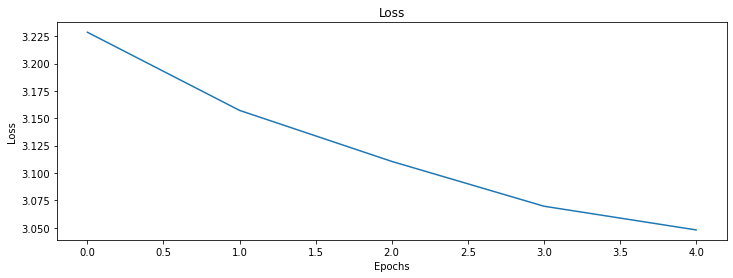

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

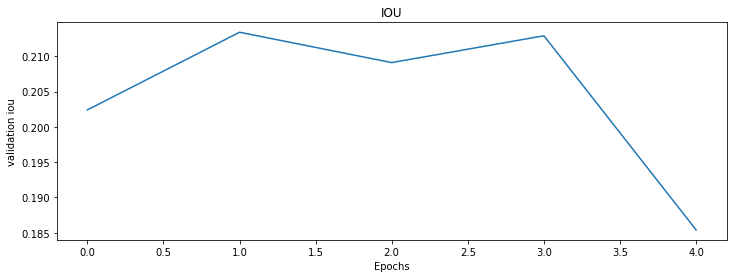

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(history.epoch, history.history["val_iou"])
plt.title('IOU')
plt.xlabel("Epochs")
plt.ylabel("validation iou")
plt.show()

# Model 3

<img src='https://miro.medium.com/max/742/1*XFvQWA4VESeQIcxzXMHCAg.png'>

In [ ]:
def depth_conv_block(layer_in,channels,s=1):
    layer_in=keras.layers.DepthwiseConv2D(kernel_size=(3,3),strides=(s,s),padding='same')(layer_in)
    layer_in=keras.layers.BatchNormalization()(layer_in)
    layer_in=keras.layers.Activation('relu')(layer_in)
    layer_in=Conv2D(channels,(1,1))(layer_in)
    layer_in=keras.layers.BatchNormalization()(layer_in)
    layer_in=keras.layers.Activation('relu')(layer_in)
    return layer_in

def conv_block(layer_in,channels,s=1,f=3):
    layer_in=Conv2D(channels,(f,f),strides=(s,s),padding='same')(layer_in)
    layer_in=keras.layers.BatchNormalization()(layer_in)
    layer_in=keras.layers.Activation('relu')(layer_in)
    return layer_in

visible=keras.layers.Input(shape=(128,128,1))
layer=conv_block(visible,6,s=2)
layer=depth_conv_block(layer,6)
layer=conv_block(layer,12,s=1,f=1)
layer=depth_conv_block(layer,12,s=2) 
layer=conv_block(layer,18,s=1,f=1)
layer=depth_conv_block(layer,18,s=1) 
layer=conv_block(layer,18,s=1,f=1)
layer=depth_conv_block(layer,18,s=2) 
layer=conv_block(layer,24,s=1,f=1)
layer=depth_conv_block(layer,24,s=1)
layer=conv_block(layer,24,s=1,f=1)
layer=depth_conv_block(layer,24,s=2)
layer=conv_block(layer,30,s=1,f=1)  
for _ in range(3):
    layer=depth_conv_block(layer,30,s=1)
    layer=conv_block(layer,30,s=1,f=1) 
layer=depth_conv_block(layer,30,s=2)
layer=keras.layers.Activation('linear')(layer)
layer=keras.layers.AveragePooling2D((4,4))(layer)
layer=Conv2D(4,(1,1))(layer)
layer = Reshape((4,))(layer)



model = Model(inputs=visible, outputs=layer)
# summarize model
model.summary()    

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 6)         60        
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 6)         24        
_________________________________________________________________
activation (Activation)      (None, 64, 64, 6)         0         
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 64, 64, 6)         60        
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 6)         24        
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 6)         0     

In [ ]:
model.compile(loss='mean_squared_error', optimizer="adam", metrics=['accuracy']) # Regression loss is MSE

checkpoint = ModelCheckpoint("Model-Blended-{val_iou:.2f}.h5", monitor="val_iou", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max") # Stop early, if the validation error deteriorates
reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")
# Reduce learning rate if Validation IOU does not improve

history=model.fit_generator(generator=train_datagen,
                    epochs=EPOCHS,
                    callbacks=[val_data, checkpoint, reduce_lr, stop],
                    workers=THREADS,
                    use_multiprocessing=MULTI_PROCESSING,
                    shuffle=True,
                    verbose=1)

Epoch 1/5
661/662 [============================>.] - ETA: 1s - loss: 4.0917 - accuracy: 0.1699 - val_iou: 0.18289999663829803

Epoch 00001: val_iou improved from -inf to 0.18290, saving model to Model-Blended-0.18.h5
662/662 [==============================] - 1146s 2s/step - loss: 4.0916 - accuracy: 0.1700
Epoch 2/5
661/662 [============================>.] - ETA: 1s - loss: 3.7750 - accuracy: 0.1855 - val_iou: 0.20319999754428864

Epoch 00002: val_iou improved from 0.18290 to 0.20320, saving model to Model-Blended-0.20.h5
662/662 [==============================] - 1180s 2s/step - loss: 3.7777 - accuracy: 0.1855
Epoch 3/5
661/662 [============================>.] - ETA: 1s - loss: 3.6430 - accuracy: 0.1874 - val_iou: 0.20509999990463257

Epoch 00003: val_iou improved from 0.20320 to 0.20510, saving model to Model-Blended-0.21.h5
662/662 [==============================] - 1168s 2s/step - loss: 3.6406 - accuracy: 0.1873
Epoch 4/5
661/662 [============================>.] - ETA: 1s - loss: 3

Text(0, 0.5, 'Loss')

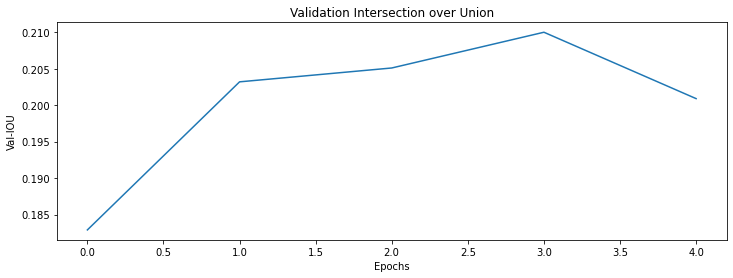

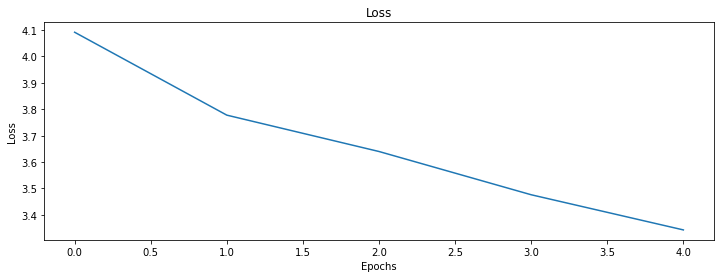

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(history.epoch, history.history["val_iou"])
plt.title('Validation Intersection over Union')
plt.xlabel("Epochs")
plt.ylabel("Val-IOU")
plt.figure(figsize=(12,4))
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")



In [ ]:
plt.figure(figsize=(12,4))
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

- Potenital reason for why mobilenet did not perform better is because , mobilenet takes image size of (96,128,196,224) but our image size is 1024 but we have resized it to 128 , since the image is a grey scale image there lies high sparcity, hence resizing is not a good idea . For our computational constraint , we have resized the image 

# Key Highlights for you from model  

- For Computational Constraints we have used very less number of filters

- We have tried to blend SSD & State of Art Model

- We are not using Fully Connected Layer as we are using 1x1 convolution as a fully connected layer 

- Models have poorly performed due to less number of filters and also because our image is of grey-scale, of size 1024x1024 but when we are using them as input , it has been converted as 128x128. As the grey scale image is already sparced, when we resize it to 128x128 it looses on lot of information.



# Post Interim

## Common Loss Function

In [ ]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred,axis=1)
    union = tf.reduce_sum(y_true,axis=1) + tf.reduce_sum(y_pred,axis=1)
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))


## Load Train & Test Set

In [ ]:
train_X=pd.read_csv('/content/drive/My Drive/Train_X.csv')
val_X=pd.read_csv('/content/drive/My Drive/Val_X.csv')

## Model Parameters

In [ ]:

IMAGE_SIZE = 512 # Image sizes can vary (128, 160, 192, 224)

EPOCHS = 5 
BATCH_SIZE = 32 
PATIENCE = 10 # Patience for early stopping

MULTI_PROCESSING = False 
THREADS = 1 


# Resnet MultiBox

## Re-Load Datagen for 512 size Images

In [ ]:
train_datagen = DataSequence(train_X)
val_data=Validation(generator=DataSequence(val_X))

## Define ResNet Re-Defined Model

In [ ]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    layer2_br= Conv2D(512,(3,3),padding='same',activation='relu')(x)
    layer3=Conv2D(512,(1,1))(layer2_br)
    layer4=Conv2D(128,(1,1))(layer3)
    layer4=Conv2D(256,(3,3),strides=(2,2),name='convsame',padding='same',activation='relu')(layer4)#Add 3rd FC layer to it
    layer5=Conv2D(64,(1,1))(layer4)
    layer5=Conv2D(128,(3,3),strides=(2,2),padding='same',activation='relu')(layer5)#Add 4rth FC layer to it
    layer6=keras.layers.AveragePooling2D((3,3))(layer5)
    layer7=Conv2D(4,(1,1),activation='relu')(layer6)#Add 5th FC layer to it
    #layer6=Conv2D(128,(1,1))(layer5)
    #layer6=Conv2D(256,(3,3))(layer6)#Add 5rth FC layer to it 

    #Adding First Fully Connected Layer
    flatlayer1_br=keras.layers.Flatten()(x)
    flatlayer1_br= keras.layers.Dense(4,activation='relu')(flatlayer1_br)
    #Adding Second Fully Connected Layer
    flatlayer2_br = keras.layers.Flatten()(layer2_br)
    flatlayer2_br=  keras.layers.Dense(4,activation='relu')(flatlayer2_br)

    #Adding Third Fully Connected Layer
    flatlayer4=keras.layers.Flatten()(layer4)
    flatlayer4=keras.layers.Dense(4,activation='relu')(flatlayer4)

    #Adding Fourth Fully Connected Layer
    flatlayer5=keras.layers.Flatten()(layer5)
    flatlayer5=keras.layers.Dense(4,activation='relu')(flatlayer5)

#Adding Fifth and Final Fully Connected Layer
    flatlayer7=keras.layers.Flatten()(layer7)
    flatlayer7=keras.layers.Dense(4,activation='relu')(flatlayer7)

# Adding Flat Layers

    Add_Final=keras.layers.add([flatlayer1_br,flatlayer2_br,flatlayer4,flatlayer5,flatlayer7])

    flatlayer8=keras.layers.Dense(4,activation="relu")(Add_Final)
    #clf_layer_br=keras.layers.Flatten()(layer6)
    #clf_layer=keras.layers.Dense(1,activation="sigmoid")(clf_layer_br)
    #merge_layer=keras.layers.concatenate([flatlayer8,clf_layer],axis=-1)

    #model = Model(inputs=visible, outputs=merge_layer)


    model = keras.Model(inputs=inputs, outputs=flatlayer8)
    return model

## Initialize Model

In [ ]:
model = create_network(input_size=512, channels=8, n_blocks=2, depth=4)


## Loading 15 epoch trained model weights

In [ ]:
model.load_weights('model-h1vgg1-0.20.h5')

## Compile & Output

In [ ]:
optimizer=keras.optimizers.Adam(learning_rate=.01)
model.compile(loss=iou_bce_loss, optimizer="rmsprop", metrics=[mean_iou])
def cosine_annealing(x):
  lr = 0.001
  epochs = 5
  return lr*(np.cos(np.pi*x/epochs)+1.)/2

learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)
#model.compile(optimizer='adam', loss=iou_bce_loss,  metrics=['accuracy', mean_iou])
checkpoint = ModelCheckpoint("model-h1vgg1-{val_iou:.2f}.h5", monitor="val_iou", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max") # Stop early, if the validation error deteriorates
reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-5, verbose=1, mode="max")
# Reduce learning rate if Validation IOU does not improve

history=model.fit_generator(generator=train_datagen,
                    epochs=EPOCHS,
                    callbacks=[val_data, checkpoint, reduce_lr, stop,learning_rate],
                    workers=THREADS,
                    use_multiprocessing=MULTI_PROCESSING,
                    shuffle=True,
                    verbose=1)

Epoch 1/5
662/662 [==============================] - ETA: 0s - loss: 2.1453 - mean_iou: 0.7494  - val_iou: 0.18615098297595978

Epoch 00001: val_iou improved from -inf to 0.18615, saving model to model-h1vgg1-0.19.h5
662/662 [==============================] - 13739s 21s/step - loss: 2.1453 - mean_iou: 0.7494 - val_iou: 0.1862 - lr: 0.0010
Epoch 2/5
662/662 [==============================] - ETA: 0s - loss: 2.1453 - mean_iou: 0.7494 - val_iou: 0.19671760499477386

Epoch 00002: val_iou improved from 0.18615 to 0.19672, saving model to model-h1vgg1-0.20.h5
662/662 [==============================] - 2199s 3s/step - loss: 2.1453 - mean_iou: 0.7494 - val_iou: 0.1967 - lr: 9.0451e-04
Epoch 3/5
662/662 [==============================] - ETA: 0s - loss: 2.1453 - mean_iou: 0.7494 - val_iou: 0.18894167244434357

Epoch 00003: val_iou did not improve from 0.19672
662/662 [==============================] - 2206s 3s/step - loss: 2.1453 - mean_iou: 0.7494 - val_iou: 0.1889 - lr: 6.5451e-04
Epoch 4/5
6

# VGG Pretrained Weights

## Model Parameters

In [ ]:

IMAGE_SIZE = 224 # Image sizes can vary (128, 160, 192, 224)

EPOCHS = 15 
BATCH_SIZE = 32 
PATIENCE = 10 # Patience for early stopping

MULTI_PROCESSING = False 
THREADS = 1 


## Data Image Generator For 3 channels

In [ ]:
#msk= np.zeros(img.shape)
class DataSequence(tf.keras.utils.Sequence):

    def __init__(self, data):
        self.paths = []
        #self.mask=[]
        #self.msk= np.zeros(img.shape)
        self.coords=np.zeros((data.shape[0],4))
        for index,row in data.iterrows():
            for i,r in enumerate(row[1:5]):
                row[i+1]=int(r)
            path,xmin,xmax,ymin,ymax,_=row
            #msk[ymin:ymax,xmin:xmax]=1
            #self.mask.append(msk)
            self.coords[index,0]=xmin/IMAGE_SIZE
            self.coords[index,1]=ymin/IMAGE_SIZE
            self.coords[index,2]=xmax/IMAGE_SIZE
            self.coords[index,3]=ymax/IMAGE_SIZE
            #self.coords[index,4]=Target
            self.paths.append(path)
        

        
    def __len__(self):
        return math.ceil(len(self.coords) / BATCH_SIZE)

    def __getitem__(self, idx): # Get a batch
        batch_paths = self.paths[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE] # Image path
        batch_coords = self.coords[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE] # Image coords

        batch_images = np.zeros((len(batch_paths), IMAGE_SIZE, IMAGE_SIZE,3), dtype=np.float32)
        for i, f in enumerate(batch_paths):
            #img = Image.open(f) # Read image
            img = pydicom.dcmread(f).pixel_array
            img = np.expand_dims(img, -1)
            img=array_to_img(img)
            img=img.resize((IMAGE_SIZE, IMAGE_SIZE))
            #img = resize(img, (IMAGE_SIZE, IMAGE_SIZE), mode='reflect')
            img = img.convert('RGB')
            

            batch_images[i] = preprocess_input(np.array(img, dtype=np.float32)) # Convert to float32 array
            #img.close()

        return batch_images, batch_coords
    

In [ ]:
class Validation(Callback):
    def __init__(self, generator):
        self.generator = generator

    def on_epoch_end(self, epoch, logs):
        intersections = 0
        unions = 0

        for i in range(len(self.generator)):
            batch_images, gt = self.generator[i] # Get batch
            pred = self.model.predict_on_batch(batch_images) # Predict bbox on batch

            # Compute interection of predicted (pred) and ground truth (gt) bounding boxes
            diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
            diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
            intersection = diff_width * diff_height

            # Compute union
            area_gt = gt[:,2] * gt[:,3]
            area_pred = pred[:,2] * pred[:,3]
            union = area_gt + area_pred - intersection

            # Compute intersection and union over multiple boxes
            for j, _ in enumerate(union):
                if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
                    intersections += intersection[j]
                    unions += union[j]

        # Compute IOU. Use epsilon to prevent division by zero
        smooth = tf.ones(tf.shape(intersections))
        #tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))
        iou = tf.reduce_mean((intersections+smooth) / (unions - intersections + smooth ))
        logs["val_iou"] = iou

        print(" - val_iou: {}".format(iou))
        

## Data Generation

In [ ]:
train_datagen = DataSequence(train_X)
val_data=Validation(generator=DataSequence(val_X))

## Model Definition

In [ ]:
def create_model(trainable=True):

  model=VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),include_top=False,weights='imagenet')
  for layer in model.layers:
    layer.trainable=trainable
  layer1_br = model.layers[-5].output
  layer2_br= Conv2D(512,(3,3),padding='same',activation='relu')(layer1_br)#Add 2nd FC layer to it 
  layer3=Conv2D(512,(1,1))(layer2_br)
  layer4=Conv2D(128,(1,1))(layer3)
  layer4=Conv2D(256,(3,3),strides=(2,2),name='convsame',padding='same',activation='relu')(layer4)#Add 3rd FC layer to it
  layer5=Conv2D(64,(1,1))(layer4)
  layer5=Conv2D(128,(3,3),strides=(2,2),padding='same',activation='relu')(layer5)#Add 4rth FC layer to it
  layer6=tf.keras.layers.AveragePooling2D((3,3))(layer5)
  layer7=Conv2D(4,(1,1))(layer6)#Add 5th FC layer to it
  #R_layer= Reshape((4,))(layer7)
  flatlayer1_br=tf.keras.layers.Flatten()(layer1_br)
  flatlayer1_br= tf.keras.layers.Dense(4,activation='relu')(flatlayer1_br)
  #Adding Second Fully Connected Layer
  flatlayer2_br = tf.keras.layers.Flatten()(layer2_br)
  flatlayer2_br=  tf.keras.layers.Dense(4,activation='relu')(flatlayer2_br)

  #Adding Third Fully Connected Layer
  flatlayer4=tf.keras.layers.Flatten()(layer4)
  flatlayer4=tf.keras.layers.Dense(4,activation='relu')(flatlayer4)

  #Adding Fourth Fully Connected Layer
  flatlayer5=tf.keras.layers.Flatten()(layer5)
  flatlayer5=tf.keras.layers.Dense(4,activation='relu')(flatlayer5)

  #Adding Fifth and Final Fully Connected Layer
  flatlayer7=tf.keras.layers.Flatten()(layer7)
  flatlayer7=tf.keras.layers.Dense(4,activation='relu')(flatlayer7)

  # Adding Flat Layers

  Add_Final=tf.keras.layers.concatenate([flatlayer1_br,flatlayer2_br,flatlayer4,flatlayer5,flatlayer7])

  flatlayer8=tf.keras.layers.Dense(4)(Add_Final)

 
  #model = Model(inputs=visible, outputs=flatlayer8)
  return tf.keras.Model(inputs=model.input, outputs=flatlayer8)




## Model Creation and Summary

In [ ]:
model=create_model(False)

In [ ]:
model.summary()

Model: "model_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_40[0][0]                   
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
___________________________________________________________________________________________

## Model Compilation & Output

In [ ]:
#optimizer=keras.optimizers.SGD(learning_rate=.01,nesterov=True,momentum=.9)
model.compile(loss=iou_bce_loss, optimizer='adam', metrics=[mean_iou])
def cosine_annealing(x):
  lr = 0.001
  epochs = EPOCHS
  return lr*(np.cos(np.pi*x/epochs)+1.)/2

learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)
#model.compile(optimizer='adam', loss=iou_bce_loss,  metrics=['accuracy', mean_iou])
checkpoint = ModelCheckpoint("model-h1vgg1-{val_iou:.2f}.h5", monitor="val_iou", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max") # Stop early, if the validation error deteriorates
reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-5, verbose=1, mode="max")
# Reduce learning rate if Validation IOU does not improve

history=model.fit_generator(generator=train_datagen,
                    epochs=EPOCHS,
                    callbacks=[val_data, checkpoint, reduce_lr, stop,learning_rate],
                    workers=THREADS,
                    use_multiprocessing=MULTI_PROCESSING,
                    shuffle=True,
                    verbose=1)

Epoch 1/15
662/662 [==============================] - ETA: 0s - loss: 3.7321 - mean_iou: -0.3117 - val_iou: 1.0

Epoch 00001: val_iou improved from -inf to 1.00000, saving model to model-h1vgg1-1.00.h5
662/662 [==============================] - 9746s 15s/step - loss: 3.7321 - mean_iou: -0.3117 - val_iou: 1.0000 - lr: 0.0010
Epoch 2/15
662/662 [==============================] - ETA: 0s - loss: 4.3075 - mean_iou: -0.5123 - val_iou: 1.0

Epoch 00002: val_iou did not improve from 1.00000
662/662 [==============================] - 872s 1s/step - loss: 4.3075 - mean_iou: -0.5123 - val_iou: 1.0000 - lr: 9.8907e-04
Epoch 3/15
662/662 [==============================] - ETA: 0s - loss: 4.6908 - mean_iou: inf - val_iou: 1.0

Epoch 00003: val_iou did not improve from 1.00000
662/662 [==============================] - 890s 1s/step - loss: 4.6908 - mean_iou: inf - val_iou: 1.0000 - lr: 9.5677e-04
Epoch 4/15
662/662 [==============================] - ETA: 0s - loss: 4.4619 - mean_iou: -2.6515 - val_i

# Segmentation - ResNet Architecture

## Data Generation

In [ ]:
pneumonia_locations = {}
# load table
with open('/content/drive/My Drive/Capstone/stage_2_train_labels.csv', mode='r') as infile:
  # open reader
  reader = csv.reader(infile)
  # skip header
  next(reader, None)
  # loop through rows
  for rows in reader:
    # retrieve information
    filename = rows[0]
    location = rows[1:5]
    pneumonia = rows[5]
    # if row contains pneumonia add label to dictionary
    # which contains a list of pneumonia locations per filename
    if pneumonia == '1':
      # convert string to float to int
      location = [int(float(i)) for i in location]
      # save pneumonia location in dictionary
      if filename in pneumonia_locations:
        pneumonia_locations[filename].append(location)
      else:
        pneumonia_locations[filename] = [location]
folder = '/content/drive/My Drive/Capstone/train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 2560
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples
folder = '/content/drive/My Drive/Capstone/train_images'

n train samples 24126
n valid samples 2560


## Image Data Generator

In [ ]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=256, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape,dtype=float)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in pneumonia_locations:
            # loop through pneumonia
            for location in pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs,dtype=float)
            msks = np.array(msks,dtype=float)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

## Creating Data 

In [ ]:
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=False, predict=False)

## Defining Model

In [ ]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

## Initialize Model & Model Summary

In [ ]:
model = create_network(input_size=256, channels=8, n_blocks=2, depth=5)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 8)  72          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 8)  32          conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 256, 8)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Loss For Segmentation Model

In [ ]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))



## Model Compilation

In [ ]:
# create network and compiler
model.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])

# cosine learning rate annealing
PATIENCE = 10

## Model Callbacks

In [ ]:
def cosine_annealing(x):
    lr = 0.001
    epochs = 5
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
checkpoint = ModelCheckpoint("model-seg-{val_mean_iou:.2f}.h5", monitor="val_mean_iou", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="max", period=1) 
stop = EarlyStopping(monitor="val_mean_iou", patience=PATIENCE, mode="max") # Stop early, if the validation error deteriorates
reduce_lr = ReduceLROnPlateau(monitor="val_mean_iou", factor=0.2, patience=10, min_lr=1e-5, verbose=1, mode="max")


## Model Output

In [ ]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint,stop,reduce_lr], epochs=5, use_multiprocessing=False)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
753/753 [==============================] - ETA: 0s - loss: 0.4407 - accuracy: 0.9973 - mean_iou: 0.9914 
Epoch 00001: val_mean_iou improved from -inf to 1.00000, saving model to model-seg-1.00.h5
753/753 [==============================] - 19666s 26s/step - loss: 0.4407 - accuracy: 0.9973 - mean_iou: 0.9914 - val_loss: 7.1351e-05 - val_accuracy: 1.0000 - val_mean_iou: 1.0000 - lr: 0.0010
Epoch 2/5
753/753 [==============================] - ETA: 0s - loss: 4.0836e-05 - accuracy: 1.0000 - mean_iou: 1.0000
Epoch 00002: val_mean_iou did not improve from 1.00000
753/753 [==============================] - 3020s 4s/step - loss: 4.0836e-05 - accuracy: 1.0000 - mean_iou: 1.0000 - val_loss: 2.5586e-05 - val_accuracy: 1.0000 - val_mean_iou: 1.0000 - lr: 9.0451e-04
Epoch 3/5
753/753 [==============================] - ETA: 0s - loss: 2.1055e-05 - accuracy: 1.0000 - mean_iou: 1.0000
Epoch 00003: val_mean_iou did not

## Model Prediction

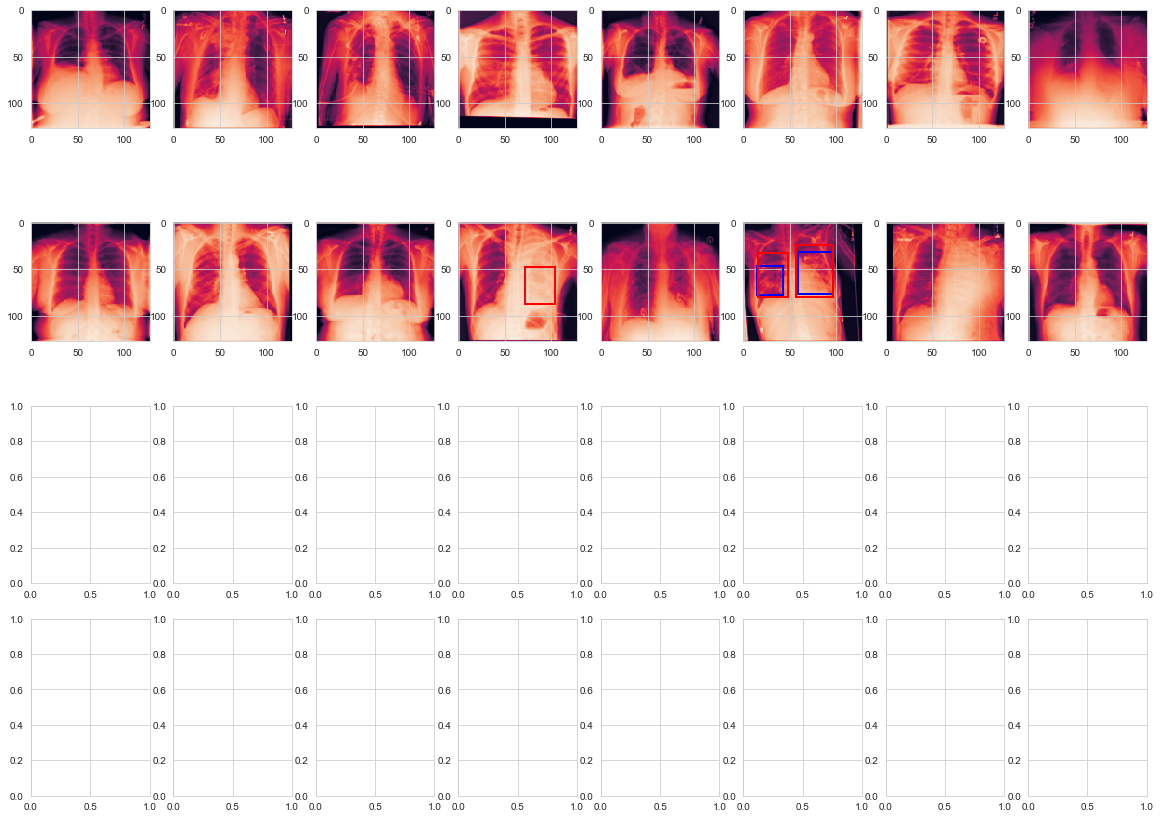

In [ ]:


for imgs, msks in valid_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        # threshold true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
    plt.show()
    # only plot one batch
    break



# Segmentation- VGG

## VGG Block Definition

In [ ]:
def vgg_block(layer_in, n_filters, n_conv):
    for _ in range(n_conv):
        layer_in = keras.layers.Conv2D(n_filters, (3,3), padding='same', activation='relu')(layer_in)
    # add max pooling layer
    layer_in = keras.layers.MaxPooling2D((2,2), strides=(2,2))(layer_in)
    return layer_in
 
# define model input


## Model Definition

In [ ]:
visible=keras.layers.Input(shape=(224,224,1))
layer=vgg_block(visible,8,2)
layer=vgg_block(layer,16,2)
layer=vgg_block(layer,32,2)
layer=vgg_block(layer,64,3)
layer=vgg_block(layer,128,3)
layer = keras.layers.BatchNormalization(momentum=0.9)(layer)
layer = keras.layers.LeakyReLU(0)(layer)
layer = keras.layers.Conv2D(1, 1, activation='sigmoid')(layer)
outputs = keras.layers.UpSampling2D(2**5)(layer)
model1 = Model(inputs=visible, outputs=outputs)

## Model Summary

In [ ]:
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 8)       80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 16)      1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 16)        0     

## Model Compilation

In [ ]:
# create network and compiler
model1.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])

# cosine learning rate annealing
PATIENCE = 3

## Callbacks Defined

In [ ]:
def cosine_annealing(x):
    lr = 0.001
    epochs = 5
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)


In [ ]:
#from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
checkpoint = ModelCheckpoint("model-seg-{val_mean_iou:.2f}.h5", monitor="val_mean_iou", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="max") 
stop = EarlyStopping(monitor="val_mean_iou", patience=PATIENCE, mode="max") # Stop early, if the validation error deteriorates
reduce_lr = ReduceLROnPlateau(monitor="val_mean_iou", factor=0.2, patience=3, min_lr=1e-5, verbose=1, mode="max")


## Model Output

In [ ]:
history = model1.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint,stop,reduce_lr], epochs=5, use_multiprocessing=False)

Epoch 1/5
753/753 [==============================] - ETA: 0s - loss: 0.4958 - accuracy: 0.9660 - mean_iou: 0.6537 
Epoch 00001: val_mean_iou improved from -inf to 0.65859, saving model to model-seg-0.66.h5
753/753 [==============================] - 13647s 18s/step - loss: 0.4958 - accuracy: 0.9660 - mean_iou: 0.6537 - val_loss: 0.4756 - val_accuracy: 0.9667 - val_mean_iou: 0.6586 - lr: 0.0010
Epoch 2/5
753/753 [==============================] - ETA: 0s - loss: 0.4683 - accuracy: 0.9664 - mean_iou: 0.6641
Epoch 00002: val_mean_iou improved from 0.65859 to 0.70248, saving model to model-seg-0.70.h5
753/753 [==============================] - 3171s 4s/step - loss: 0.4683 - accuracy: 0.9664 - mean_iou: 0.6641 - val_loss: 0.4667 - val_accuracy: 0.9707 - val_mean_iou: 0.7025 - lr: 9.0451e-04
Epoch 3/5
753/753 [==============================] - ETA: 0s - loss: 0.4568 - accuracy: 0.9673 - mean_iou: 0.6762
Epoch 00003: val_mean_iou did not improve from 0.70248
753/753 [==========================

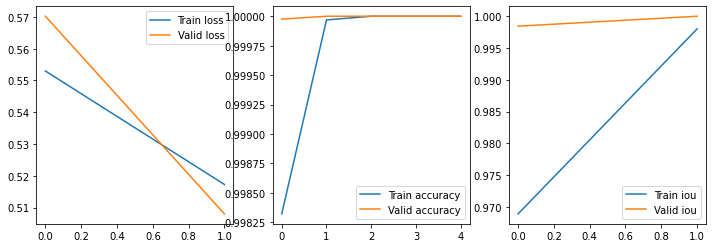

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_accuracy"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

## Prediction Output

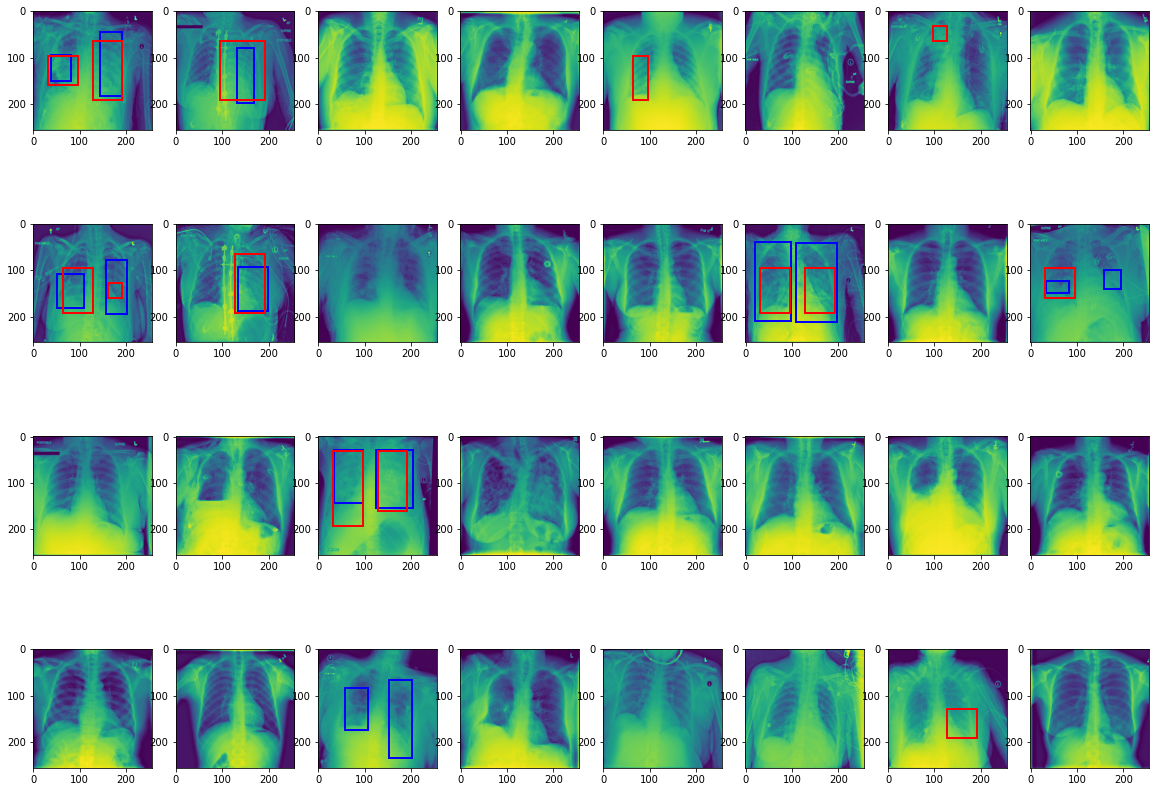

In [ ]:


for imgs, msks in valid_gen:
    # predict batch of images
    preds = model1.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        # threshold true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected componentsf
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
    plt.show()
    # only plot one batch
    break
